<a href="https://colab.research.google.com/github/KHSakib/ML_Class/blob/main/ResNet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import os
import tensorflow as tf

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils import np_utils
#from keras.optimizers import SGD

import keras
import keras.utils
from keras import utils as np_utils


import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time



In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


In [ ]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [ ]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [ ]:
X_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [ ]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
class_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
X_train.ndim

4

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_train = X_train/255
X_test = X_test/255


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= 0.2, random_state=2020)

In [ ]:
X_train.shape,  y_train.shape

((40000, 32, 32, 3), (40000, 1))

In [ ]:
X_validation.shape, y_validation.shape

((10000, 32, 32, 3), (10000, 1))

In [ ]:
def resnet(input_shape, n_classes):

  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    x = Add()([x, tensor])
    output = ReLU()(x)
    return output


  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output


  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x


  input = Input(input_shape)

  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)

  x = GlobalAvgPool2D()(x)

  output = Dense(n_classes, activation='softmax')(x)

  model = Model(input, output)
  return model

In [ ]:
input_shape = 32, 32, 3
n_classes = 10

K.clear_session()
model = resnet(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='sgd',
              loss='mse',
              metrics=[tf.keras.metrics.Accuracy(),
                       tf.keras.metrics.Precision()])

In [ ]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=1, validation_data=(X_validation, y_validation))

Epoch 1/5
79/79 [==============================] - 80s 479ms/step - loss: 2.0348 - accuracy: 0.3438 - val_loss: 2.6461 - val_accuracy: 0.1056
Epoch 2/5
79/79 [==============================] - 34s 426ms/step - loss: 1.4243 - accuracy: 0.4964 - val_loss: 3.3356 - val_accuracy: 0.1054
Epoch 3/5
79/79 [==============================] - 34s 427ms/step - loss: 1.2336 - accuracy: 0.5692 - val_loss: 3.4990 - val_accuracy: 0.1292
Epoch 4/5
79/79 [==============================] - 34s 428ms/step - loss: 1.0646 - accuracy: 0.6247 - val_loss: 2.5383 - val_accuracy: 0.2252
Epoch 5/5
79/79 [==============================] - 34s 428ms/step - loss: 0.9332 - accuracy: 0.6708 - val_loss: 3.2177 - val_accuracy: 0.2173


In [ ]:
y_pred = model.predict(X_test)
y_pred.round(2)

y_test

results = model.evaluate(X_test, y_test)

print( 'Loss = {} %'.format( results[0]))
print( 'Accuracy = {} %'.format( results[1] * 100))
print(len(results))

313/313 [==============================] - 8s 27ms/step - loss: 3.2110 - accuracy: 0.2211
Loss = 3.21102237701416 %
Accuracy = 22.110000252723694 %
2


In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in y_pred ]
cm = confusion_matrix(y_test, y_pred_labels)

<Figure size 1152x648 with 0 Axes>

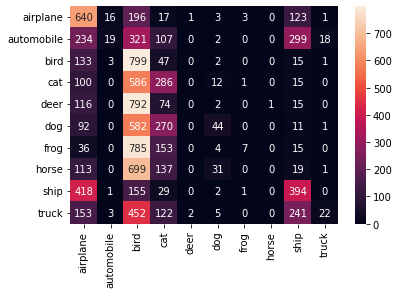

In [ ]:
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

In [ ]:
from sklearn.metrics import classification_report
cr= classification_report(y_test, y_pred_labels, target_names=class_labels)
print(cr)

              precision    recall  f1-score   support

    airplane       0.31      0.64      0.42      1000
  automobile       0.45      0.02      0.04      1000
        bird       0.15      0.80      0.25      1000
         cat       0.23      0.29      0.26      1000
        deer       0.00      0.00      0.00      1000
         dog       0.41      0.04      0.08      1000
        frog       0.58      0.01      0.01      1000
       horse       0.00      0.00      0.00      1000
        ship       0.34      0.39      0.37      1000
       truck       0.50      0.02      0.04      1000

    accuracy                           0.22     10000
   macro avg       0.30      0.22      0.15     10000
weighted avg       0.30      0.22      0.15     10000



In [ ]:
sensitivity = []
for i in range(10):
    #print("I = ",i)
    x = cm[i][i]
    sum = 0
    for j in range(10):
        if i!=j:
            sum = sum+cm[j][i]
       # print(a[j][i])

    sensitivity.append(x/(x+sum))
    #print(x+sum)

list1 = ['Sensitivity of airplane : ', 'Sensitivity of automobile : ',
         'Sensitivity of bird : ', 'Sensitivity of cat : ',
         'Sensitivity of deer : ', 'Sensitivity of dog : ',
         'Sensitivity of frog : ', 'Sensitivity of horse : ',
         'Sensitivity of ship : ', 'Sensitivity of truck : ']
for i in range(10):
    print(list1[i],sensitivity[i])


Sensitivity of airplane :  0.3144963144963145
Sensitivity of automobile :  0.4523809523809524
Sensitivity of bird :  0.14887274082355134
Sensitivity of cat :  0.23027375201288244
Sensitivity of deer :  0.0
Sensitivity of dog :  0.411214953271028
Sensitivity of frog :  0.5833333333333334
Sensitivity of horse :  0.0
Sensitivity of ship :  0.3435047951176983
Sensitivity of truck :  0.5


In [ ]:
specificity = []
for x in range(10):
    TN = 0
    FP = 0
    for i in range(10):
        for j in range(10):
            if x!=j:
                if x==i:
                    FP = FP + cm[i][j]
                else:
                    TN = TN + cm[i][j]

    ans = TN/(TN+FP)
    specificity.append(ans)

list1 = ['Specificity of airplane : ', 'Specificity of automobile : ',
         'Specificity of bird : ', 'Specificity of cat : ',
         'Specificity of deer : ', 'Specificity of dog : ',
         'Specificity of frog : ', 'Specificity of horse : ',
         'Specificity of ship : ', 'Specificity of truck : ']
for i in range(10):
    print(list1[i],specificity[i])

Specificity of airplane :  0.9548022598870056
Specificity of automobile :  0.9014862422173127
Specificity of bird :  0.9566155838549536
Specificity of cat :  0.9184745375656542
Specificity of deer :  0.8999699909972992
Specificity of dog :  0.9033660163752149
Specificity of frog :  0.9005806968362035
Specificity of horse :  0.8999899989999
Specificity of ship :  0.9315486275838699
Specificity of truck :  0.9017677782241864
